In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [72]:
df = pd.read_csv('../Data/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [7]:
df.columns = ['Sales']

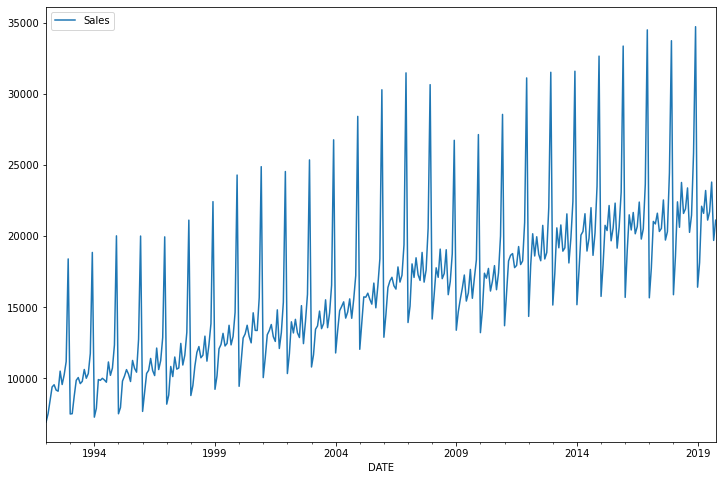

In [17]:
df.plot(figsize=(12,8))

In [14]:
len(df)

334

### Predict online 1.5 years of data

In [18]:
test_size = 18

In [20]:
test_data = len(df) - test_size

In [22]:
train = df.iloc[:test_data]
test = df.iloc[test_data:]

In [23]:
len(train)

316

In [24]:
len(test)

18

### Scale the data

In [25]:
from sklearn.preprocessing import MinMaxScaler

In [26]:
scaler = MinMaxScaler()

In [27]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

### Generate TimeSeries

In [36]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Dense,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
length=12
Generator = TimeseriesGenerator(scaled_train,scaled_train,length=length, batch_size=1)

In [43]:
n_features = 1
model = Sequential()

model.add(LSTM(100,activation = 'relu',input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [44]:
Validation_Generator = TimeseriesGenerator(scaled_test,scaled_test,length=length, batch_size=1)

In [45]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [46]:
model.fit_generator(Generator,validation_data=Validation_Generator,epochs=10,callbacks=early_stop)

Epoch 1/10
304/304 [==============================] - 2s 5ms/step - loss: 0.0270 - val_loss: 0.0060
Epoch 2/10
304/304 [==============================] - 1s 5ms/step - loss: 0.0163 - val_loss: 0.0030
Epoch 3/10
304/304 [==============================] - 2s 6ms/step - loss: 0.0102 - val_loss: 0.0024
Epoch 4/10
304/304 [==============================] - 1s 5ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 5/10
304/304 [==============================] - 1s 5ms/step - loss: 0.0050 - val_loss: 0.0011
Epoch 6/10
304/304 [==============================] - 1s 5ms/step - loss: 0.0022 - val_loss: 9.4774e-04
Epoch 7/10
304/304 [==============================] - 2s 7ms/step - loss: 0.0017 - val_loss: 7.7453e-04
Epoch 8/10
304/304 [==============================] - 1s 5ms/step - loss: 0.0016 - val_loss: 2.6263e-04
Epoch 9/10
304/304 [==============================] - 1s 5ms/step - loss: 0.0012 - val_loss: 3.6473e-04
Epoch 10/10
304/304 [==============================] - 2s 5ms/step - loss: 0.0014 - 

In [47]:
loss = pd.DataFrame(model.history.history)

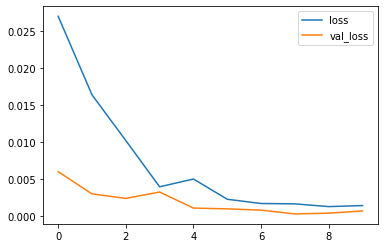

In [48]:
loss.plot()

### Evaluate test data

In [49]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [50]:
true_predictions = scaler.inverse_transform(test_predictions)

In [51]:
test['Prediction'] = true_predictions

<ipython-input-51-e52fcd9aa14e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Prediction'] = true_predictions


### Predicting the data for the last 1.5 years

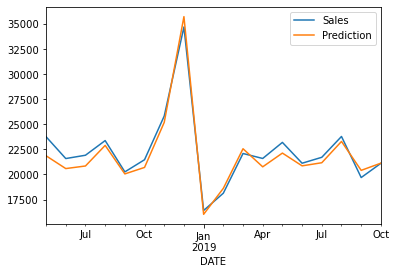

In [52]:
test.plot()

### Forcasting the new data

In [54]:
df_scaled = scaler.fit_transform(train)

In [57]:
length=12
df_Generator = TimeseriesGenerator(df_scaled,df_scaled,length=length, batch_size=1)

In [56]:
n_features = 1
model = Sequential()

model.add(LSTM(100,activation = 'relu',input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(loss='mse',optimizer='adam')

In [58]:
model.fit_generator(df_Generator,epochs=10)

Epoch 1/10
304/304 [==============================] - 1s 4ms/step - loss: 0.0243
Epoch 2/10
304/304 [==============================] - 1s 4ms/step - loss: 0.0159
Epoch 3/10
304/304 [==============================] - 1s 5ms/step - loss: 0.0083
Epoch 4/10
304/304 [==============================] - 2s 6ms/step - loss: 0.0050
Epoch 5/10
304/304 [==============================] - 1s 4ms/step - loss: 0.0036
Epoch 6/10
304/304 [==============================] - 1s 4ms/step - loss: 0.0018
Epoch 7/10
304/304 [==============================] - 1s 5ms/step - loss: 0.0021
Epoch 8/10
304/304 [==============================] - 2s 7ms/step - loss: 0.0016
Epoch 9/10
304/304 [==============================] - 2s 5ms/step - loss: 0.0012
Epoch 10/10
304/304 [==============================] - 1s 5ms/step - loss: 0.0018


In [65]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = df_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [66]:
forecast = scaler.inverse_transform(forecast)

In [67]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

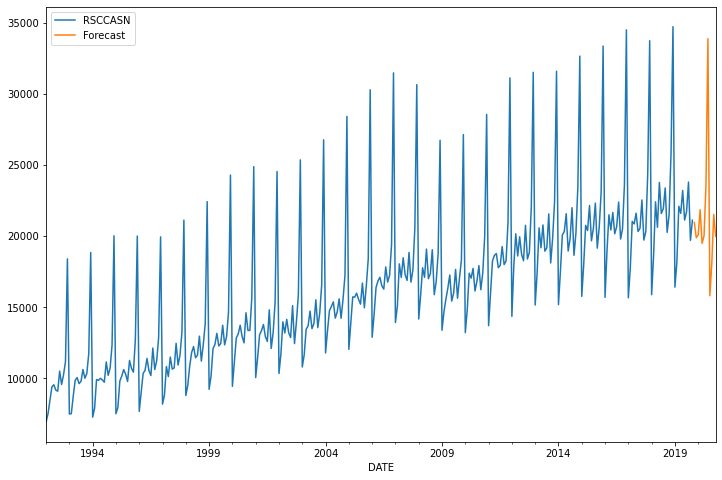

In [75]:
ax = df.plot(figsize=(12,8))
forecast_df.plot(ax=ax)